# Détection des faux Billets

Ce projet a pour but de créer un algorithme de détection de faux billets et revoir des notions vues aux épisodes précédents.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  

Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  
        - choix du nombre des composantes
        - représentation des variables par le cercle des corrélations 
        - représentation des individus par les plans factoriels 
        - analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

In [2]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#RegLog Kmeans
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

#CAH
from scipy.cluster.hierarchy import dendrogram

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit

## Data Acquisition

### Load dataset

In [4]:
cash_df = pd.read_csv('../data/notes.csv')

In [5]:
cash_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [6]:
cash_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87
169,False,171.96,104.00,103.95,5.63,3.26,110.96


### High level statistics

In [8]:
cash_df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [9]:
cash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [15]:
cash_df.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

### Observations

Il n'y aucune valeure manquantes sur un total de 170 instances de données.

Cent de ces billets sont classé comme étant de vrais, alors que les restant 70 ne le sont pas.

## Partie 1 : ANALYSES BIVARIES

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :

    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux : est-ce que visuellement on peut déterminer des caractéristiques des vrais ou des faux billets ?
    - etc -> be creative :)

### Box plot

Rapport billets vrai/faux

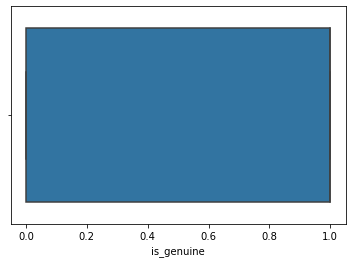

In [52]:
sns.boxplot(x=cash_df.is_genuine)
plt.show()

Le boxplot n'affiche pas le resultat souhaité car les valeurs de la faeture 'is_genuine' sont en format chaine de caractere, alors qu'il doivent étre en format int (nombre) pour qu'ils puisse étre reconnu.

On doit donc categoriser ces instances de données

#### Scikit Learn label indexing

In [40]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
cash_df['is_genuine'] = ord_enc.fit_transform(cash_df[['is_genuine']]).astype(int)
cash_df.is_genuine.head()

0    1
1    1
2    1
3    1
4    1
Name: is_genuine, dtype: int32

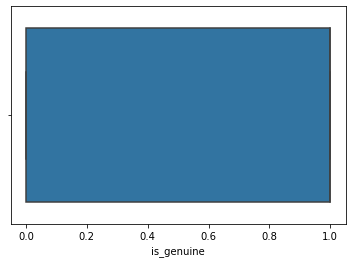

In [48]:
sns.boxplot(x=cash_df.is_genuine, hue=cash_df)
plt.show()

Les distributions de longueurs, largeurs des billets de votre dataset

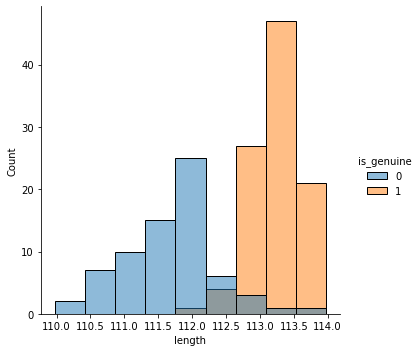

In [43]:
sns.displot(x=cash_df.length, hue=cash_df.is_genuine)

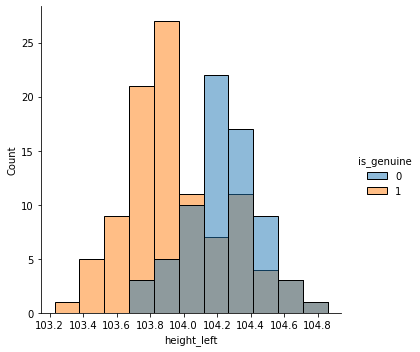

In [44]:
sns.displot(x=cash_df.height_left, hue=cash_df.is_genuine)

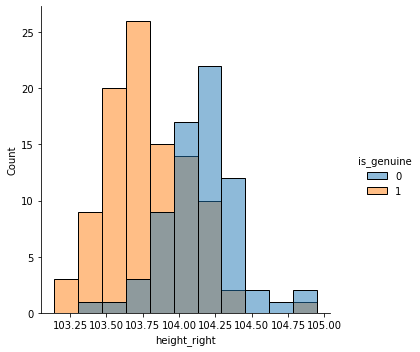

In [45]:
sns.displot(x=cash_df.height_right, hue=cash_df.is_genuine)

Distribution diagonale du billet vrai vs faux

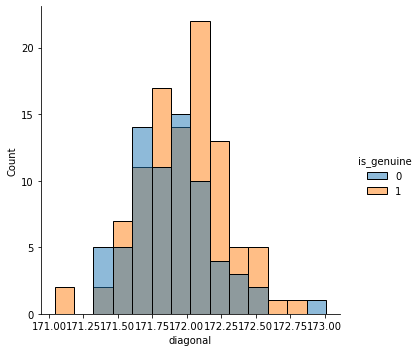

In [59]:
sns.displot(x=cash_df.diagonal, hue=cash_df.is_genuine)

Rapport longueur/largeur billets vrais vs faux

<AxesSubplot:xlabel='height_right', ylabel='length'>

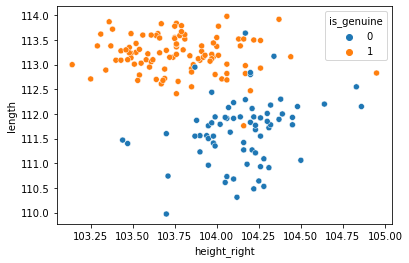

In [46]:
sns.scatterplot(x=cash_df.height_right, y=cash_df.length, hue=cash_df.is_genuine)

<AxesSubplot:xlabel='height_left', ylabel='length'>

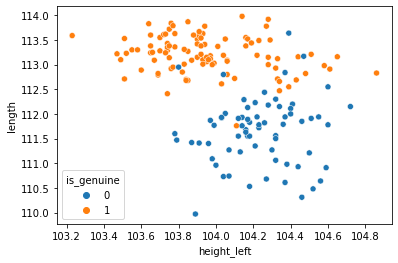

In [47]:
sns.scatterplot(x=cash_df.height_left, y=cash_df.length, hue=cash_df.is_genuine)

Rapport longueur/diagonal billet vrai/faux

<AxesSubplot:xlabel='length', ylabel='diagonal'>

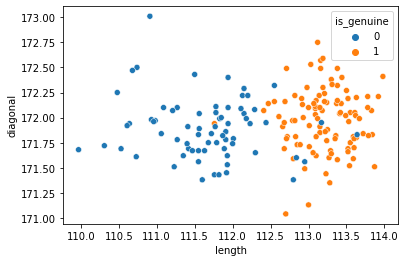

In [56]:
sns.scatterplot(x=cash_df.length, y=cash_df.diagonal, hue=cash_df.is_genuine)

Rapport hauteur/diagonal billet vrai/faux

<AxesSubplot:xlabel='height_left', ylabel='diagonal'>

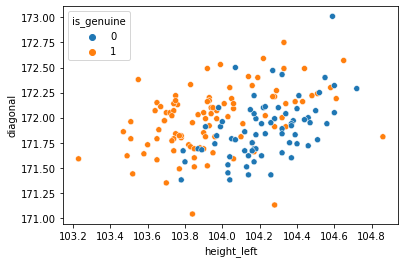

In [57]:
sns.scatterplot(x=cash_df.height_left, y=cash_df.diagonal, hue=cash_df.is_genuine)

<AxesSubplot:xlabel='height_right', ylabel='diagonal'>

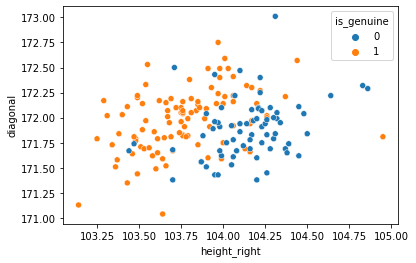

In [58]:
sns.scatterplot(x=cash_df.height_right, y=cash_df.diagonal, hue=cash_df.is_genuine)

### Observations

A partir d'environ 113mm, plus la longueur augmente plus les billets tendent à étre classé comme étant des faux et viceversa, moins ils sont longues, plus ils tenderont à étre classé comme étant de vrais.

A partir d'environ 104 mm, que soit mesurée sur le côté gauche ou droit du billet, plus l'hauteur (épaisseur) du billet augmente et plus les billets sont classés comme étant de faux et viceversa, moins ils sont épais plus ils sont classés comme étant des vrais.

Distribution des classes en prenant la diagonal comme feature principale, pas du tout nette / évidente

La repartion (classification) entre les billets vrais/faux semble étre assez evidente en correlant la largeur et la longueur du billet, qu'ils aient été mesurée sur le coté gauche ou droite, ce qui veut dire qu'il y a une correlation entre ces deux features.

La repartion (classification) entre les billets vrais/faux semble étre assez pertinente en correlant la diagonal et la longueur du billet, ce qui veut dire qu'il y a une correlation entre ces deux features.

La repartion (classification) entre les billets vrais/faux en correlant la diagonal et l'hauteur du billet, qu'ils aient été mesurée sur le coté gauche ou droite par contre ne semble pas l'étre, ce qui veut dire qu'il y a peu de correlation entre ces deux features.

### Multivariate Analysis

#### Pair plot

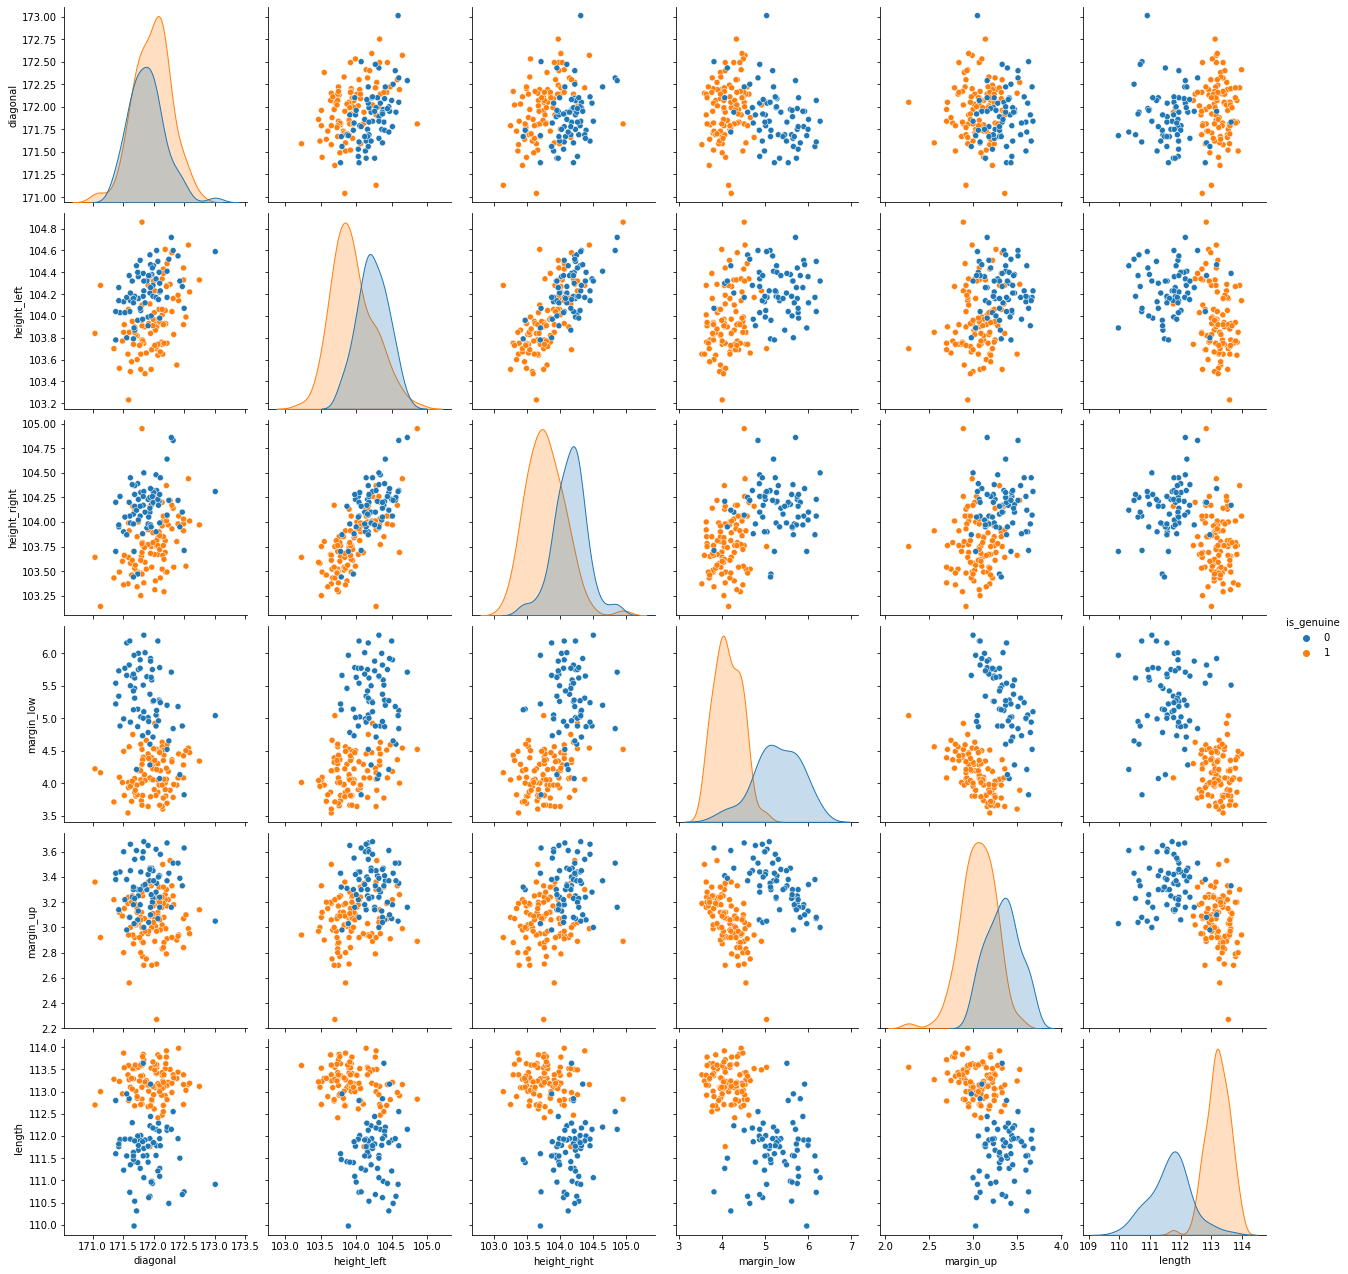

In [62]:
sns.pairplot(cash_df, hue='is_genuine', height=3)
plt.show()

## Partie 2 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir ce que j'ai cité plus haut.

### 1. Standardization

In [67]:
cash_fltd = cash_df.drop('is_genuine', axis=1)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


In [68]:
X_std = StandardScaler().fit_transform(cash_fltd)
X_std

array([[-0.42834385,  2.6694537 ,  3.09656321, -0.13159013, -1.18987367,
         0.28163308],
       [-0.88755932, -1.09769709, -0.69125444, -0.86012554, -1.27473985,
         0.78069736],
       [-0.36274164, -1.03042654, -0.50943919, -0.30301023, -1.23230676,
         1.37740465],
       ...,
       [ 1.73652911,  0.68497248,  0.52084721,  0.38267015,  0.67718214,
        -2.05094997],
       [-0.39554274, -0.32408577, -0.1458087 ,  0.16839504,  1.61071005,
        -0.75989238],
       [ 0.06367273, -0.22317994,  0.06630909,  1.45404575,  0.38015054,
        -1.74717171]])

### 2. Eigen decomposition — Computing Eigenvectors and Eigenvalues

### 2.1 Covariance Matrix

In [69]:
print('Covariance matrix \n')
cov_mat= np.cov(X_std, rowvar=False)
cov_mat

Covariance matrix 



array([[ 1.00591716,  0.32147482,  0.22172226, -0.18209153, -0.02752747,
         0.0807703 ],
       [ 0.32147482,  1.00591716,  0.73873577,  0.42704205,  0.32670946,
        -0.42388076],
       [ 0.22172226,  0.73873577,  1.00591716,  0.5123893 ,  0.36908899,
        -0.41948814],
       [-0.18209153,  0.42704205,  0.5123893 ,  1.00591716,  0.17212533,
        -0.641123  ],
       [-0.02752747,  0.32670946,  0.36908899,  0.17212533,  1.00591716,
        -0.52839204],
       [ 0.0807703 , -0.42388076, -0.41948814, -0.641123  , -0.52839204,
         1.00591716]])

### 2.2 Eigenvectors and Eigenvalues computation from the covariance matrix

In [70]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.07327499  0.77963908  0.08889419 -0.55973158  0.22509444 -0.12216606]
 [ 0.47550205  0.33925019 -0.12276016  0.2780463  -0.71592059 -0.23213146]
 [ 0.4918214   0.23554253 -0.15383022  0.45893794  0.48699285  0.4808135 ]
 [ 0.43102671 -0.32053699 -0.5128076  -0.22652773  0.31190784 -0.54763041]
 [ 0.35253984 -0.14111974  0.82114881  0.13533955  0.1939426  -0.35437971]
 [-0.46537288  0.31453645 -0.12691346  0.57370304  0.25441684 -0.52395111]]

Eigenvalues 
[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


### 3. Selecting The Principal Components

### 3.1 Sorting eigenvalues

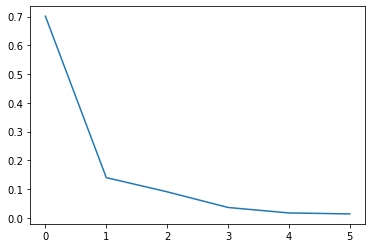

In [82]:
# defining pca
pca = PCA()
C = pca.fit(cash_fltd).transform(cash_fltd)

# sorting eigenvalues
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Partie 3 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  